In [1]:
import os
import cv2
import numpy as np
#import layers
import matplotlib.pyplot as plt

In [2]:
# credits to https://towardsdatascience.com/lines-detection-with-hough-transform-84020b3b1549

import matplotlib.lines as mlines

# ist a,b == m, c

def line_detection_non_vectorized(image, edge_image, num_rhos=100, num_thetas=100, t_count=220):
  edge_height, edge_width = edge_image.shape[:2]
  edge_height_half, edge_width_half = edge_height / 2, edge_width / 2
  #
  d = np.sqrt(np.square(edge_height) + np.square(edge_width))
  dtheta = 180 / num_thetas
  drho = (2 * d) / num_rhos
  #
  thetas = np.arange(0, 180, step=dtheta)
  rhos = np.arange(-d, d, step=drho)
  #
  cos_thetas = np.cos(np.deg2rad(thetas))
  sin_thetas = np.sin(np.deg2rad(thetas))
  #
  accumulator = np.zeros((len(rhos), len(rhos)))
  #
  figure = plt.figure(figsize=(12, 12))
  subplot1 = figure.add_subplot(1, 4, 1)
  subplot1.imshow(image, cmap="gray")
  subplot2 = figure.add_subplot(1, 4, 2)
  subplot2.imshow(edge_image, cmap="gray")
  subplot3 = figure.add_subplot(1, 4, 3)
  subplot3.set_facecolor((0, 0, 0))
  subplot4 = figure.add_subplot(1, 4, 4)
  subplot4.imshow(image, cmap="gray")
  #
  for y in range(edge_height):
    for x in range(edge_width):
      if edge_image[y][x] != 0:
        edge_point = [y - edge_height_half, x - edge_width_half]
        ys, xs = [], []
        for theta_idx in range(len(thetas)):
          rho = (edge_point[1] * cos_thetas[theta_idx]) + (edge_point[0] * sin_thetas[theta_idx])
          theta = thetas[theta_idx]
          rho_idx = np.argmin(np.abs(rhos - rho))
          accumulator[rho_idx][theta_idx] += 1
          ys.append(rho)
          xs.append(theta)
        subplot3.plot(xs, ys, color="white", alpha=0.05)
  line_results = list()
  for y in range(accumulator.shape[0]):
    for x in range(accumulator.shape[1]):
      if accumulator[y][x] > t_count:
        rho = rhos[y]
        theta = thetas[x]
        #print(theta)
        a = np.cos(np.deg2rad(theta))
        b = np.sin(np.deg2rad(theta))

        x0 = (a * rho) + edge_width_half
        #print(x0)

        y0 = (b * rho) + edge_height_half
        #print(y0)
        x1 = int(x0 + 1000 * (-b))
        y1 = int(y0 + 1000 * (a))
        x2 = int(x0 - 1000 * (-b))
        y2 = int(y0 - 1000 * (a))
        #print([x1, x2])
        #print([y1, y2])
        #print("###")
        subplot3.plot([theta], [rho], marker='o', color="yellow")
        line_results.append([(x1,y1), (x2,y2)])
        subplot4.add_line(mlines.Line2D([x1, x2], [y1, y2]))

  subplot3.invert_yaxis()
  subplot3.invert_xaxis()

  subplot1.title.set_text("Original Image")
  subplot2.title.set_text("Edge Image")
  subplot3.title.set_text("Hough Space")
  subplot4.title.set_text("Detected Lines")
  plt.show()
  return accumulator, rhos, thetas, line_results

(720, 960)


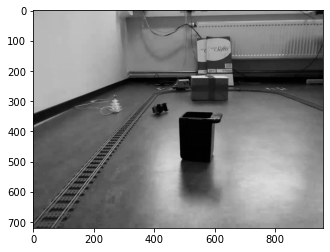

In [3]:
img = cv2.imread(f"C:/Users/fredi/Desktop/Uni/SELS2/hough2/handpicked_rails/2021-07-01-17-07-48/fps_1_frame_018.jpg",  cv2.IMREAD_GRAYSCALE)
#img = cv2.imread(img_dir, cv2.IMREAD_GRAYSCALE)
print(img.shape)
plt.imshow(img, "gray")
plt.show()

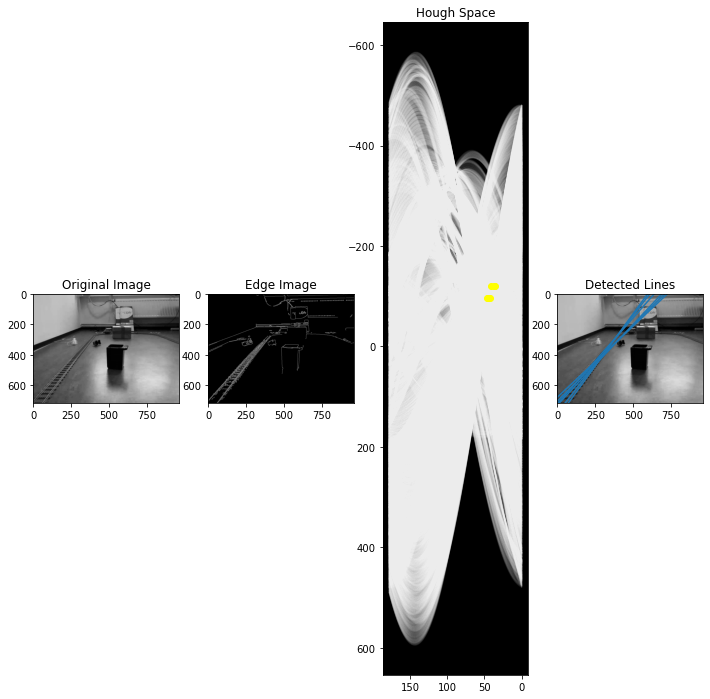

In [9]:
edge_image = cv2.Canny(img, 100, 200)
acc, rhos, thetas, line_results = line_detection_non_vectorized(img, edge_image, t_count=3500)

In [10]:
def test_pixel(edge_image, x, y,threshold=3):
    x, y = round(x), round(y)
    max_x, max_y = len(edge_image[0])-1, len(edge_image)-1
    if (x-threshold) >= 0 and (x+threshold) <= max_x and (y-threshold) >= 0 and (y+threshold) <= max_y:
        for i in range(threshold):
            for j in range(threshold):
                if (edge_image[y+i][x+i] == 255) or (edge_image[y-i][x+i] == 255) or\
                (edge_image[y+i][x-i] == 255) or (edge_image[y-i][x-i] == 255):
                    return [x, y, True]
        
    return [x, y, False]

In [11]:
def merge_lines_manual(edge_image, lines):
    
    new_lines = []
    for line in lines:
        x0, y0, x1, y1 = line[0][0], line[0][1], line[1][0], line[1][1]
        if x1 == x0:
            slope = False
        elif y0 == y1:
            slope = 0
        else:
            slope = (y1-y0)/(x1-x0)
        
        line_label = []
        if slope == False:
            x = x0
            if y1 > y0:
                big_y, small_y = y1, y0
            elif y0 > y1:
                big_y, small_y = y0, y1
            else: #in this case x0=x1 and y0=y1 -> there is no line
                continue
            
            for y in range(small_y, big_y):
                line_label.append([x,y,test_pixel(edge_image, x, y)])
            
            
        elif slope == 0:
            y = y0
            if x1 > x0:
                big_x, small_x = x1, x0
            elif x0 > x1:
                big_x, small_x = x0, x1
            else: #in this case x0=x1 and y0=y1 -> there is no line
                continue
            for x in range(small_x, big_x):
                line_label.append([x,y,test_pixel(edge_image, x, y)])
        
        else:
            y_direction = 0
            if abs(x0-x1) > abs(y0-y1):
                if x1 > x0:
                    start_x, end_x = x0, x1
                    start_y, end_y = y0, y1
                else:
                    start_x, end_x = x1, x0
                    start_y, end_y = y1, y0
                y = start_y
                for x in range(start_x, end_x):
                    line_label.append(test_pixel(edge_image, x, y))
                    y = y + slope
                    if y1 > y0:
                        if y < y0 or y > y1:
                            break
                    if y1 < y0:
                        if y > y0 or y < y1:
                            break
            elif abs(y0-y1) > abs(x0-x1):    # y distance is bigger than x so we count up y instead of x
                if y1 > y0:
                    start_x, end_x = x0, x1
                    start_y, end_y = y0, y1
                else:
                    start_x, end_x = x1, x0
                    start_y, end_y = y1, y0
                
                x = start_x
                for y in range(start_y, end_y):
                    line_label.append(test_pixel(edge_image, x, y))
                    x = x + 1/slope
                    if x1 > x0:
                        if x < x0 or x > x1:
                            break
                    if x1 < x0:
                        if x > x0 or x < x1:
                            break
        new_lines.append(line_label)
    return new_lines

In [12]:
print(line_results)

[[(-204, 1098), (970, -519)], [(-227, 1076), (998, -503)], [(-271, 1030), (1051, -469)], [(-274, 1023), (1094, -434)], [(-294, 999), (1119, -414)], [(-314, 974), (1143, -394)]]


In [13]:
def check_pixel_range(pixel_i, pixel_j, line_slope, threshold):
    if abs(line_slope) > threshold:
        threshold = abs(line_slope)
    x0,y0 = pixel_i[0],pixel_i[1]
    x1,y1 = pixel_j[0],pixel_j[1]
    if abs(x0-x1) > threshold or abs(y0-y1) > threshold:
        return False
    else:
        return True

In [27]:
def cut_lines(new_lines, threshold=25):
    true_lines = []
    for line in new_lines:
        true_pixels = []
        for pixel in line:
            if pixel[2] == True:
                true_pixels.append([pixel[0], pixel[1]])
        true_lines.append(true_pixels)
    
    line_lengths=[]
    for line in true_lines:
        print(len(line))
        if len(line) > 0:
            start, end = line[0], line[len(line)-1]
            slope = (end[1]-start[1]) / (end[0]-start[0])
            length_counter=[[line[0], False, 0]]   #format: [line:[start, end, length]]
            current_segment=0
            for i in range(len(line) - 1):
                check = check_pixel_range(line[i], line[i+1], slope, threshold)
                if check == True:
                    length_counter[current_segment][2] += 1
                else:
                    length_counter[current_segment][1] = line[i]
                    length_counter.append([line[i+1], False, 0])
                    current_segment += 1
            length_counter[len(length_counter)-1][1] = line[len(line)-1]
            line_lengths.append(length_counter)
                
    return line_lengths

In [28]:
new_lines = merge_lines_manual(edge_image, line_results)
#print(new_lines[0])
draw_lines = []
for line in new_lines:
    true_pixels = []
    for pixel in line:
        if pixel[2] == True:
            true_pixels.append(pixel)
    end_point = len(true_pixels) - 1
    #drawing whole line for the beginning
    if len(true_pixels) > 0:
        draw_lines.append([(true_pixels[0][0],true_pixels[0][1]),(true_pixels[end_point][0],true_pixels[end_point][1])])

#start and end coordinates for each line fit the original lines
print(draw_lines)


[[(582, 16), (84, 702)], [(596, 15), (97, 658)], [(625, 14), (24, 696)], [(674, 13), (42, 686)], [(90, 595), (711, 12)]]


In [29]:
lines = cut_lines(new_lines, 30)

final_lines = []
for line in lines:
    biggest_segment_index, biggest_segment_val = 0, 0
    for i in range(len(line)):
        if line[i][2] > biggest_segment_val:
            biggest_segment_index = i
            biggest_segment_val = line[i][2]
    final_lines.append([line[biggest_segment_index][0], line[biggest_segment_index][1]])
print(final_lines)

479
389
454
362
0
392
[[[447, 202], [84, 702]], [[451, 202], [97, 658]], [[459, 202], [24, 696]], [[500, 199], [93, 632]], [[90, 595], [511, 199]]]


In [30]:
lines = cut_lines(new_lines, 30)

479
389
454
362
0
392


447 202 [84, 702]
451 202 [97, 658]
459 202 [24, 696]
500 199 [93, 632]
90 595 [511, 199]


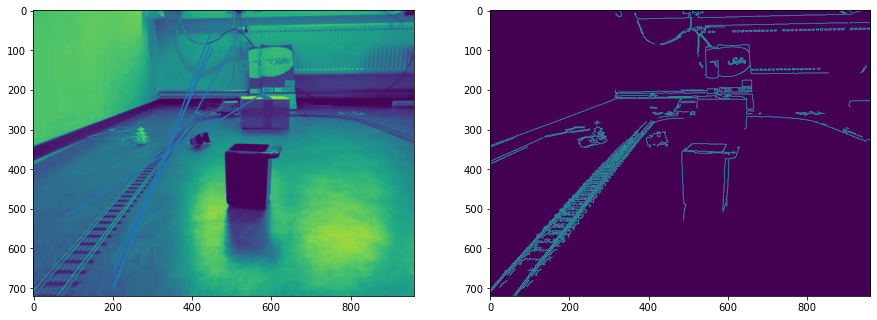

In [33]:
fig, axes = plt.subplots(1, 2, figsize=(15, 6))
ax = axes.ravel()

for line in final_lines:
    print(line[0][0], line[0][1], [line[1][0], line[1][1]])
    ax[0].add_line(mlines.Line2D([line[0][0], line[0][1]], [line[1][0], line[1][1]]))
    #ax[0].add_line(mlines.Line2D([line[1][0], line[1][1]], [line[0][0], line[0][1]]))
    #ax[0].plot(line[0], line[1], color="blue", linewidth=2)

    
ax[0].imshow(img)
ax[1].imshow(edge_image)